In [1]:
from pytorch_tools import CreateDataset, train_model_cls, train_model_reg, plot_metrics
from callbacks import EarlyStoppingCallback, ReduceLROnPlateauCallback, ModelCheckpointCallback
from train_models import ClassifierTrainer

/Users/aleksejkitajskij/Desktop/DS-Lifehacks/pytorch/pytorch_tools.py:19: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/opt/anaconda3/envs/goit/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## multyclass classification

In [2]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import TargetEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('data/Module_2_Lecture_2_Class_penguins.csv')
df = df.dropna().reset_index(drop=True)
features = ['species', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
df = df.loc[:, features]
df.loc[df['species']=='Adelie', 'species']=0
df.loc[df['species']=='Gentoo', 'species']=1
df.loc[df['species']=='Chinstrap', 'species']=2
df = df.apply(pd.to_numeric)

In [4]:
X = df.drop('species', axis =1).values
y = df['species'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size =0.33, stratify=y)

X_train = torch.Tensor(X_train).float()
y_train = torch.Tensor(y_train).long()
X_test = torch.Tensor(X_test).float()
y_test = torch.Tensor(y_test).long()

In [5]:
train_dataset = CreateDataset(X_train, y_train, scaler='StandardScaler')
test_dataset = CreateDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset,
                              batch_size=20,
                              num_workers=0
                             )

test_dataloader = DataLoader(test_dataset,
                              batch_size=20,
                              num_workers=0
                             )

In [6]:
num_classes = len(np.unique(y_train))
num_classes

3

In [7]:
class Net(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim=20, out_dim=3):
        super().__init__()
        
        self.features = torch.nn.Sequential(
            
            nn.Linear(in_dim, hidden_dim),
            torch.nn.ReLU(),
            
            nn.Linear(hidden_dim, out_dim),
            nn.Softmax()
        )    
        
    def forward(self, x):
        output = self.features(x)
        return output

In [8]:
model = Net(X_train.shape[1], 20, num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [9]:
early_stop = EarlyStoppingCallback(
    patience=10,
    min_delta=0.001,
)

reduce_lr = ReduceLROnPlateauCallback(optimizer=optimizer,
                                      patience=5, 
                                      factor=0.5,
                                      min_delta=0.01)

best_model = ModelCheckpointCallback(path='best_model.pt', min_delta=0.1)

In [10]:
callbacks = [early_stop, reduce_lr, best_model]

In [11]:
trainer = ClassifierTrainer(model=model,
                            criterion=criterion,
                            optimizer=optimizer,
                            num_classes=num_classes,
                            device='mps',
                            callbacks=callbacks)

trainer.fit(train_dataloader,
            test_dataloader,
            num_epoch=1000,
            info_every_iter=10,
            show_val_metrics=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [10/1000] Train Loss: 0.9874 Acc: 0.6447 Rec: 0.6447 Prec: 0.5176


Epoch [20/1000] Train Loss: 0.9015 Acc: 0.6557 Rec: 0.6557 Prec: 0.5332


Epoch [30/1000] Train Loss: 0.8372 Acc: 0.6633 Rec: 0.6633 Prec: 0.5409
Epoch [40/1000] Train Loss: 0.7953 Acc: 0.6633 Rec: 0.6633 Prec: 0.5409
Epoch [50/1000] Train Loss: 0.7683 Acc: 0.6633 Rec: 0.6633 Prec: 0.5409


Epoch [60/1000] Train Loss: 0.7522 Acc: 0.6633 Rec: 0.6633 Prec: 0.5409


Epoch [70/1000] Train Loss: 0.7475 Acc: 0.6633 Rec: 0.6633 Prec: 0.5409


Epoch [80/1000] Train Loss: 0.7464 Acc: 0.6633 Rec: 0.6633 Prec: 0.5409


In [12]:
model = trainer.model
metrics = trainer.metrics

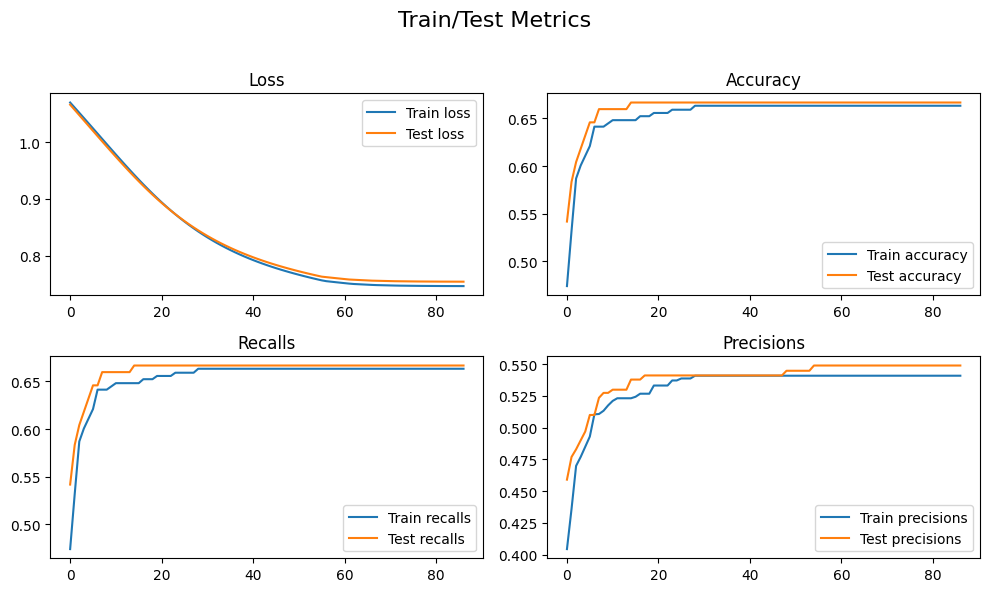

In [13]:
plot_metrics(metrics)